### gnomad data deal
#### gnomad data were download from GnomAD3.1.2 （URL: https://gnomad.broadinstitute.org/downloads）, and used those bash shell to filter.


In [ ]:
# @gnomad.tsvTrans.py
import gzip
import re
import sys
#AC=1;AN=33673;AF=2.96974e-05;
with gzip.open(sys.argv[1],'rt')as fr,open(sys.argv[2],'w')as fw:
    for line in fr:
        if line.startswith("#"): continue
        chromosome,pos,ID,ref,alt,anno,fiter,info=line.strip().split("\t")
        pp = re.match(".*AC=(\d*);AN=(\d*);AF=(.*?);",info)
        ac,an,af=pp[1],pp[2],pp[3]
        vep = re.match('.*vep=(.*)|',info)
        if not vep[1]:
            fw.write("\t".join([chromosome,pos,str(int(pos)+1),ref,alt,ac,an,af,"NA"])+"\n")
        else:
            tmp = []
            for _ in vep[1].split(","):
                tmp.append("|".join(_.split("|")[:4]))
            fw.write("\t".join([chromosome,pos,str(int(pos)+1),ref,alt,ac,an,af,",".join(tmp)])+"\n")


#### commad
``` bcftools filter --threads 4 -i '%TYPE="snp" && %FILTER="PASS" && lcr==0 && segdup==0' -o gnomad.genomes.v3.1.sites.chr*.pass_snps.vcf.gz -O z /public1/home/Suilab/GnomAD/gnomad.genomes.v3.1.2.sites.chr*.vcf.bgz```
```python gnomad.tsvTrans.py gnomad.genomes.v3.1.sites.chr*.pass_snps.vcf.gz gnomad.genomes.v3.1.sites.chr*.pass_snps.tsv```
```cat gnomad.genomes.v3.1.sites.chr*.pass_snps.tsv |gzip > gnomad.genomes.v3.1.sites.pass_snps.tsv.gz```
#### file type
```chr1	821401	821402	G	A	2346	144942	0.0161858	A|downstream_gene_variant|MODIFIER|FAM87B ```
#### commad
```
cd /disk2/G4_MS/reference
cat /disk2/G4_MS/promoter_select/promoter_info/promoter.annotion.tsv /disk2/G4_MS/promoter_select/promoter_info/promoter_info.annotion.H3K4me3.tsv |cut -f1-3|grep -v "Chromosome"|sort -k1,1 -k2,2n|uniq|bedtools merge -i - |awk -v OFS="\t" '{print $1,$2-200,$3+200}' | bedtools intersect -a gnomad.genomes.v3.1.sites.pass_snps.tsv.gz -b - -wa -sorted |gzip > promoter_gnomad.genomes.v3.1.sites.pass_snps.tsv.gz

```

#### constraint LOEUF metric download from GnomAD: https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/constraint/gnomad.v2.1.1.lof_metrics.by_transcript.txt.bgz
```
reference:
The mutational constraint spectrum quantified from variation in 141,456 humans. Nature 581, 434–443 (2020)
```

#### allele frequency analysis 
``` 
the constraint non-promoter method was referred to Lee et.al,Integrative analysis reveals RNA G-quadruplexes in UTRs are selectively constrained and enriched for functional associations,Nat Commun,2020.
```
 

meta NOT subset; don't know how to subset; dropped


<Figure size 640x480 with 0 Axes>

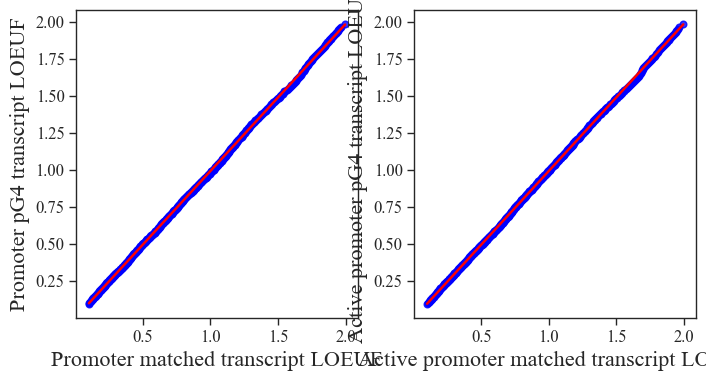

tssg4 gruns 0.0
tssg4_stable gruns  0.0
tssg4_unstable gruns  0.0
*******
activate promoter gruns  0.0
activate promoter stabe gruns  0.0
activate promoter unstable gruns 0.0


meta NOT subset; don't know how to subset; dropped


<Figure size 400x400 with 0 Axes>

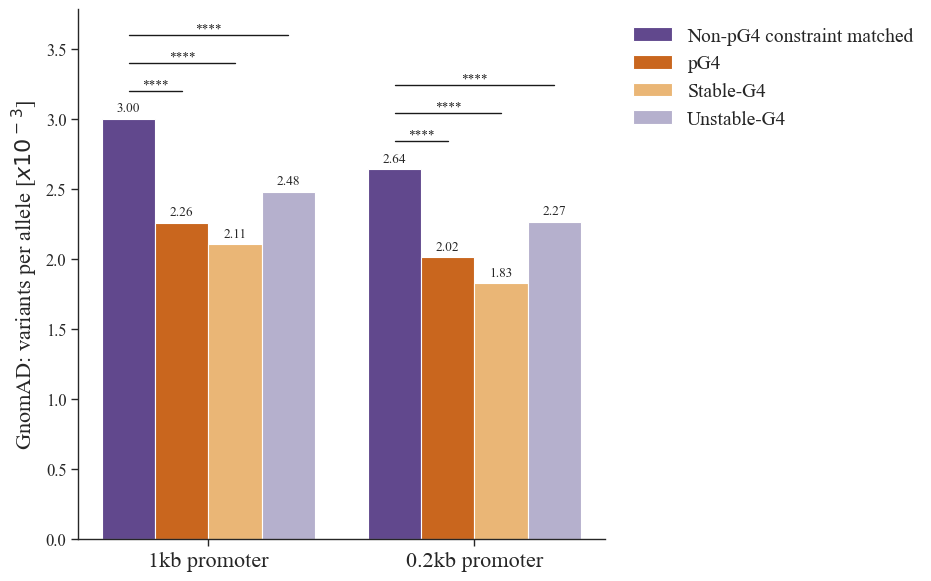

tssG4: flank1 vs nonG4 0.0
tssG4: G4 vs nonG4 0.0
tssG4: flank2 vs nonG4 0.0
tssG4: G4 vs flank 0.0
eG4: flank1 vs nonG4 0.0
eG4: G4 vs nonG4 0.0
eG4: flank2 vs nonG4 0.0
eG4: G4 vs flank 0.0
tssG4_stable: flank1 vs nonG4 0.0
tssG4_stable: G4 vs nonG4 0.0
tssG4_stable: flank2 vs nonG4 0.0
tssG4_stable: G4 vs flank 0.0
eG4_stable: flank1 vs nonG4 0.0
eG4_stable: G4 vs nonG4 0.0
eG4_stable: flank2 vs nonG4 0.0
eG4_stable: G4 vs flank 0.0
tssG4_stable: flank1 vs nonG4 0.0
tssG4_stable: G4 vs nonG4 0.0
tssG4_stable: flank2 vs nonG4 0.0
tssG4_stable: G4 vs flank 0.0
eG4_stable: flank1 vs nonG4 0.0
eG4_stable: G4 vs nonG4 0.0
eG4_stable: flank2 vs nonG4 0.0
eG4_stable: G4 vs flank 0.0


meta NOT subset; don't know how to subset; dropped


<Figure size 400x400 with 0 Axes>

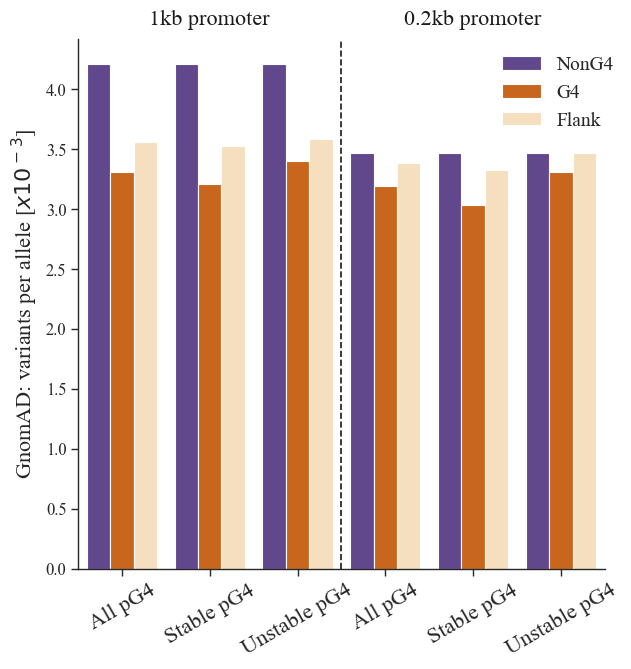

meta NOT subset; don't know how to subset; dropped


<Figure size 600x600 with 0 Axes>

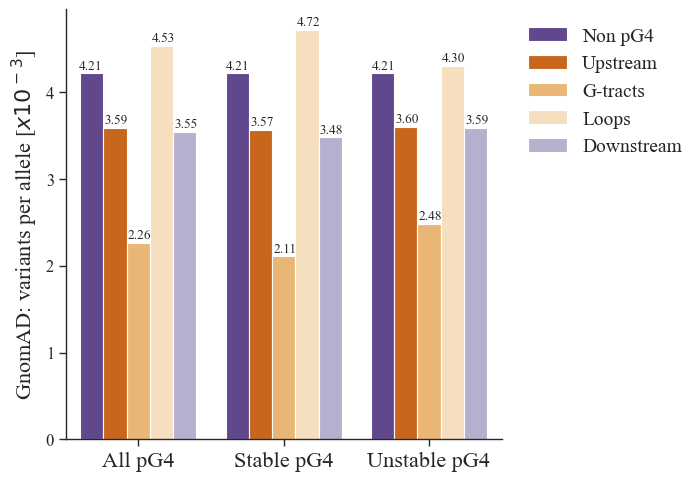

meta NOT subset; don't know how to subset; dropped


<Figure size 600x600 with 0 Axes>

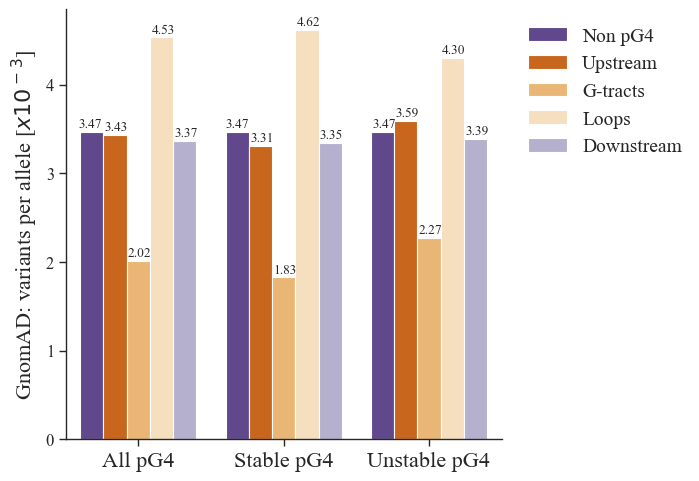

In [8]:
import os, sys, gzip
import pandas as pd
import numpy as np
import pyranges as pr
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats
from itertools import groupby
import re


## 
def x2test(G4ac, G4an, noG4ac, noG4an):
    G4ac = int(G4ac)
    G4an = int(G4an)
    noG4ac = int(noG4ac)
    noG4an = int(noG4an)
    matric = [[G4ac, noG4ac], [G4an - G4ac, noG4an - noG4ac]]
    return scipy.stats.chi2_contingency(matric)

def Fisher_exat(G4ac, G4an, noG4ac, noG4an):
    G4ac = int(G4ac)
    G4an = int(G4an)
    noG4ac = int(noG4ac)
    noG4an = int(noG4an)
    matric = [[G4ac, G4an - G4ac], [noG4ac, noG4an - noG4ac]]
    return scipy.stats.fisher_exact(matric)[1]

def constrant_random_select(oriconstrant_table, constrant_table, n):
#     def tmp(df,n):
#         if df.shape[0] < n:
#             return df
#         else:
#             return df.sample(n, random_state=100)

    constrant_quantile = oriconstrant_table["oe_lof_upper"].quantile([0.25, 0.5, 0.75])
    df_q1 = constrant_table[constrant_table["oe_lof_upper"] < constrant_quantile[0.25]]
    df_q2 = constrant_table[(constrant_table["oe_lof_upper"] >= constrant_quantile[0.25]) & (
            constrant_table["oe_lof_upper"] < constrant_quantile[0.5])]
    df_q3 = constrant_table[(constrant_table["oe_lof_upper"] >= constrant_quantile[0.5]) & (
            constrant_table["oe_lof_upper"] < constrant_quantile[0.75])]
    df_q4 = constrant_table[constrant_table["oe_lof_upper"] >= constrant_quantile[0.75]]
    
    select_N = min([df_q1.shape[0],df_q2.shape[0], df_q3.shape[0], df_q4.shape[0]])
    if select_N < n:
        n = select_N
    df_q1 = df_q1.sample(n, random_state=100)
    df_q2 = df_q2.sample(n, random_state=100)
    df_q3 = df_q3.sample(n, random_state=100)
    df_q4 = df_q4.sample(n, random_state=100)
    df = pd.concat([df_q1, df_q2, df_q3, df_q4])
    return df.transcript

def file_check(workpath):
    if not os.path.exists(workpath):
        print(f"{workpath} is not exist, the procession will be exit!!!")
        sys.exist(1)
    else:
        return workpath

def G4a_all_get(df):
    result = []
    df = df.drop_duplicates(keep="first")
    df = df[df.Name.map(lambda x:len(x)) <100]
    for index, row in df.iterrows():
        plusflg = True
        if row["Strand"] == "-": plusflg = False
        # tp_track = Gtrack_get(row.Name, plus=plusflg)
        if plusflg:
            flank1 = [row.Chromosome, row.Start - 100, row.Start, "+", "flank1"]
            flank2 = [row.Chromosome, row.End, row.End + 100, "+", "flank2"]
            G4 = [row.Chromosome, row.Start, row.End, "+", "G4"]
        else:
            flank2 = [row.Chromosome] + [row.Start - 100, row.Start, "-", "flank2"]
            flank1 = [row.Chromosome] + [row.End, row.End + 100, "-", "flank1"]
            G4 = [row.Chromosome, row.Start, row.End, "-", "G4"]
        result += [flank1, G4, flank2]
    return result

def Gtrack_get(seq, plus=True):
    result = []
    ggg = []
    seqindex = []
    for index, val in enumerate(list(seq)):
        if plus:
            if val == 'g' or val == 'G':
                ggg.append(index)
        else:
            if val == 'c' or val == 'C':
                ggg.append(index)
    for k, g in groupby(enumerate(ggg), lambda x: x[1] - x[0]):
        _ = [j for i, j in g]
        if len(_) >= 3:
            seqindex.append(_)
    if len(seqindex) > 0:
        for idx in seqindex:
            result.append((idx[0], idx[-1] + 1))
    return result

def G4_info(df):
    result = []
    df = df.drop_duplicate_positions(keep="first")
    df = df[df.Name.map(lambda x:len(x)) < 100]
    for index, row in df.as_df().iterrows():
        plusflg = True
        if row.Strand == "-": plusflg = False
        tp_track = Gtrack_get(row.Name, plus=plusflg)
        gtract_count = 0
        if plusflg:
            flank1 = [row.Chromosome, row.Start + tp_track[0][0] - 100, row.Start + tp_track[0][0], "+", "flank1"]
            flank2 = [row.Chromosome, row.Start + tp_track[-1][1], row.Start + tp_track[-1][1] + 100, "+", "flank2"]
            result += [flank1,flank2]
            while gtract_count < len(tp_track):
                gtract_index = tp_track[gtract_count]
                stem = [row.Chromosome] + [int(row.Start) + gtract_index[0], 
                                           int(row.Start)+gtract_index[1]] + ["+", "stem{}".format(gtract_count+1)]
                result.append(stem)
                if gtract_count != len(tp_track)-1:
                    loop_index = [tp_track[gtract_count][1], tp_track[gtract_count+1][0]]
                    loop = [row.Chromosome] + [int(row.Start) + loop_index[0], 
                                               int(row.Start)+ loop_index[1]] + ["+", "loop{}".format(gtract_count+1)]
                    result.append(loop)
                gtract_count += 1
        else:
            flank2 = [row.Chromosome] + [row.Start + tp_track[0][0] - 100, row.Start + tp_track[0][0], "-", "flank2"]
            flank1 = [row.Chromosome] + [row.Start + tp_track[-1][1], row.Start + tp_track[-1][1] + 100, "-", "flank1"]
            result += [flank1,flank2]
            while gtract_count < len(tp_track):
                gtract_index = tp_track[gtract_count]
                stem = [row.Chromosome] + [int(row.Start) + gtract_index[0], 
                                           int(row.Start)+gtract_index[1]] + ["-", "stem{}".format(len(tp_track) - gtract_count)]
                result.append(stem)
                if gtract_count != len(tp_track)-1:
                    loop_index = [tp_track[gtract_count][1], tp_track[gtract_count+1][0]]
                    loop = [row.Chromosome] + [int(row.Start) + loop_index[0], 
                                               int(row.Start)+ loop_index[1]] + ["+", "loop{}".format(len(tp_track) - gtract_count)]
                    result.append(loop)
                gtract_count += 1
    return result

def chromosome_filter(gr_df, constrant_id, constrant=False):
    gr_df = gr_df[(gr_df.Chromosome != "chrX") & (gr_df.Chromosome != "chrY")]
    gr_df.transcript_id = gr_df.transcript_id.map(lambda x: x.split(".")[0])
    if constrant:
        gr_df = gr_df[gr_df.transcript_id.isin(constrant_id)]
    return gr_df

def foo(tmp):
    if len(tmp) > 1:
        tt = tmp[0]
        tmp_index_list = [int(_[5]) for _ in tmp]
        tmp_index = tmp_index_list.index(max(tmp_index_list))
        tt[4] = tmp[tmp_index][4]
        tt[5] = sum(tmp_index_list)
        tt[6] = max([int(_[6]) for _ in tmp])
        tt[7] = tt[5]/tt[6]
        tt[8] = tmp[tmp_index][8]
    else:
        tt = tmp[0]
        tt[5] = int(tt[5])
        tt[6] = int(tt[6])
        tt[7] = float(tt[7])
    return tt

class G4Deal():
    def __init__(self, G4):
        self.G4 = pr.PyRanges(pd.DataFrame(G4_info(G4.max_disjoint(slack=100)), columns=["Chromosome","Start","End","Strand", "Name"]))
    def G4_subtype(self,cds):
        self.gruns = self.G4[self.G4.Name.isin(["stem"+str(i) for i in range(40)])].subtract(cds, strandedness = False)
        self.loops = self.G4[self.G4.Name.isin(["loop"+str(i) for i in range(40)])].subtract(cds, strandedness = False)
        self.flank1 = self.G4[self.G4.Name.isin(["flank1"])].subtract(cds, strandedness = False)
        self.flank2 = self.G4[self.G4.Name.isin(["flank2"])].subtract(cds, strandedness = False)
        self.g4 = self.G4[self.G4.Name.isin(["stem"+str(i) for i in range(40)] + ["loop"+str(i) for i in range(40)])
                         ].subtract(cds, strandedness = False)
        self.flank = self.G4[self.G4.Name.isin(["flank1","flank2"])].subtract(cds, strandedness = False)
        
    def snp_overlap(self,snp):
        self.gruns_snp = snp.overlap(self.gruns, strandedness=False)
        self.loops_snp = snp.overlap(self.loops, strandedness=False)
        self.flank1_snp = snp.overlap(self.flank1, strandedness=False)
        self.flank2_snp = snp.overlap(self.flank2, strandedness=False)
        self.g4_snp = snp.overlap(self.g4, strandedness=False)
        self.flank_snp = snp.overlap(self.flank, strandedness=False)
    
    def ac_an_count(self):
        self.gruns_snp_ac, self.gruns_snp_an = self.gruns_snp.AC.sum(), self.gruns_snp.AN.sum()
        self.loops_snp_ac, self.loops_snp_an = self.loops_snp.AC.sum(), self.loops_snp.AN.sum()
        self.flank1_snp_ac, self.flank1_snp_an = self.flank1_snp.AC.sum(), self.flank1_snp.AN.sum()
        self.flank2_snp_ac, self.flank2_snp_an = self.flank2_snp.AC.sum(), self.flank2_snp.AN.sum()
        self.g4_snp_ac, self.g4_snp_an = self.g4_snp.AC.sum(), self.g4_snp.AN.sum()
        self.flank_snp_ac, self.flank_snp_an = self.flank_snp.AC.sum(), self.flank_snp.AN.sum()


def gene_select(G4info, nonG4info, genes, key="cgc"):
    result = []
    G4info_gene = G4info[G4info.gene_id.isin(genes)]
    G4info_gene.as_df().to_csv(os.path.join(wd_path,key + "G4.genes.annotinon.tsv"),sep="\t",index=False)
    G4info_stable_gene = G4info_gene[G4info_gene.Score > 19]
    G4info_unstable_gene = G4info_gene[G4info_gene.Score <= 19]
    for p in [G4info_gene, G4info_stable_gene, G4info_unstable_gene]:
        p=G4Deal(p)
        p.G4_subtype(cds)
        p.snp_overlap(snp)
        p.ac_an_count()
        result.append(p)
    nonG4_genes = nonG4info[nonG4info.gene_id.isin(genes)]
    print(key)
    print("G4 all genes:", G4info_gene.gene_id.drop_duplicates().shape[0],"|||G4 stable genes: ",
         G4info_stable_gene.gene_id.drop_duplicates().shape[0], "|||G4 unstable genes: ",
         G4info_unstable_gene.gene_id.drop_duplicates().shape[0],"|||NonG4genes: ",
         nonG4_genes.gene_id.drop_duplicates().shape[0],"|||overlap genes:", 
         len(set(G4info_gene.gene_id).intersection(set(nonG4_genes.gene_id)))
         )
    nonG4_genes_gruns = gruns.overlap(nonG4_genes,strandedness=False)
    nonG4_genes_gruns_snp = snp.overlap(nonG4_genes_gruns)
    nonG4_genes_snp = snp.overlap(nonG4_genes)
    
    nonG4_genes_gruns_snp_ac, nonG4_genes_gruns_snp_an = nonG4_genes_gruns_snp.AC.sum(), nonG4_genes_gruns_snp.AN.sum()
    nonG4_genes_snp_ac, nonG4_genes_snp_an = nonG4_genes_snp.AC.sum(), nonG4_genes_snp.AN.sum()
    return result,nonG4_genes_gruns_snp_ac, nonG4_genes_gruns_snp_an, nonG4_genes_snp_ac, nonG4_genes_snp_an

def write_df(G4_genes,nonG4_genes, key, tss=True):
    """
    G4_genes: the dict type data restore the G4 genes class info
    nonG4_genes: the dict type data restore the non G4 genes snp AC and AN numbers
    key: geneSet selected such as Cancer Gene Census (cgc), tsg and clinvar genes
    tss: whether the analysis is promoter or active promoter
    """
    if tss:
        nonG4Number = 0
        pos_start = 0
        pos_end = 3
        promoter = "Promoter"
    else:
        nonG4Number = 4
        pos_start = 3
        pos_end = 6
        promoter = "Active promoter"
    stem_loop = {}
    stem_loop["sample"] = ["Flank1"]*3 + ["G-tracts"]*3 + ["Loops"]*3 + ["Flank2"]*3 + ["NonG4_G-tracts"]*3 + ["NonG4"]*3
    stem_loop["ac"] = [
        p.flank1_snp_ac for p in G4_genes[key][pos_start:pos_end]] + [
        p.gruns_snp_ac for p in G4_genes[key][pos_start:pos_end]] + [
        p.loops_snp_ac for p in G4_genes[key][pos_start:pos_end]] + [
        p.flank2_snp_ac for p in G4_genes[key][pos_start:pos_end]]+ [
        nonG4_genes[key][nonG4Number],nonG4_genes[key][nonG4Number],nonG4_genes[key][nonG4Number]]+[
        nonG4_genes[key][nonG4Number+2],nonG4_genes[key][nonG4Number+2],nonG4_genes[key][nonG4Number+2]
    ]
        
    stem_loop["an"] = [
        p.flank1_snp_an for p in G4_genes[key][pos_start:pos_end]] + [
        p.gruns_snp_an for p in G4_genes[key][pos_start:pos_end]] + [
        p.loops_snp_an for p in G4_genes[key][pos_start:pos_end]] + [
        p.flank2_snp_an for p in G4_genes[key][pos_start:pos_end]]+ [
        nonG4_genes[key][nonG4Number+1],nonG4_genes[key][nonG4Number+1],nonG4_genes[key][nonG4Number+1]]+[
        nonG4_genes[key][nonG4Number+3],nonG4_genes[key][nonG4Number+3],nonG4_genes[key][nonG4Number+3]
    ]

    stem_loop["groups"] = ["G4", "Stable-G4", "Unstable-G4"]*6
    stem_loop["promoter_class"] = [promoter]*18
    stem_loop = pd.DataFrame(stem_loop)
    stem_loop.sort_values("groups")
    stem_loop.loc[:,"frequency"] = stem_loop.apply(lambda x: x["ac"]/x["an"] *1000,axis=1)
    return stem_loop
        
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def cancergene_fig_ploted(df,outputFileName,titles):
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']

    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})

    ax = sns.catplot(x="groups", y="frequency",hue="sample",kind="bar",
                     hue_order=["NonG4","NonG4_G-tracts","Flank1","G-tracts","Loops","Flank2"],
                palette=['#542788','#998ec3','#b35806','#f1a340','#fee0b6','#d8daeb'],
                height=6,data=df,
                legend=False
           )

    xrange=[
            -0.05, 0.95, 1.95, 
            0.07, 1.07, 2.07, 
            0.2, 1.2, 2.2,
            0.33, 1.34, 2.34,
            -0.2, 0.8, 1.8, 
            -0.34, 0.68, 1.68
            
           ]
    for x,y in zip(xrange,df.frequency): # get the height of each bar 
        plt.text(x = x , 
            y = y + 0.05, # y-coordinate position of data label, padded 100 above bar 
            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals 
            ha = 'center') # sets horizontal alignment (ha) to center
    
    plt.title("{titles}".format(titles=titles),size=20)
    plt.xticks([0,1,2],["G4","Stable-G4","Unstable-G4"], size=16)

    plt.yticks(size=12)
    plt.xlabel('',size=16)
    plt.ylabel( "GnomAD: variants per allele [$x10^-$$^3$]", size=16)

    plt.legend(title = "", fontsize = 14, title_fontsize = 14, bbox_to_anchor=(1.02,1),frameon=False)
    plt.savefig(outputFileName)

if __name__ == "__main__":
    wd_path = "/disk2/G4_MS/frequency/gruns_gnomad_frequency"
    if not os.path.exists(wd_path):
        os.mkdir(wd_path)
    reference_path = file_check("/disk2/G4_MS/reference")
    constrant = pd.read_table(os.path.join(reference_path,"gnomad.v2.1.1.lof_metrics.by_transcript.txt"))
    cds = pr.read_bed(os.path.join(reference_path,"gencode38.cds_region.bed"))
    
    G4_path = file_check("/disk2/G4_MS/promoter_select/promoter_info")
    tss_prmtr_G4_path = file_check(os.path.join(G4_path,"promoter_pG4.info.tsv"))
    tss_prmtr_noG4_path = file_check(os.path.join(os.path.join(G4_path,"promoter_nopG4.info.tsv")))
    
    ac_prmtr_G4_path = file_check(os.path.join(G4_path,"promoter_pG4.info.H3K4me3.tsv"))
    ac_prmtr_noG4_path = file_check(os.path.join(G4_path,"promoter_nopG4.info.H3K4me3.tsv"))
    
    tssG4 = pr.PyRanges(pd.read_table(tss_prmtr_G4_path))
    tssG4_ori = chromosome_filter(tssG4,constrant.transcript)
    tssNonG4_ori = pr.PyRanges(pd.read_table(tss_prmtr_noG4_path))
    tssNonG4 = chromosome_filter(tssNonG4_ori,constrant.transcript, constrant=True)
    
    tssG4_stable_ori = tssG4_ori[tssG4_ori.Score > 19]
    tssG4_unstable_ori = tssG4_ori[tssG4_ori.Score <= 19]
    
    eG4 = pr.PyRanges(pd.read_table(ac_prmtr_G4_path))
    eG4_ori = chromosome_filter(eG4,constrant.transcript)
    eNonG4_ori = pr.PyRanges(pd.read_table(ac_prmtr_noG4_path))
    eNonG4 = chromosome_filter(eNonG4_ori, constrant.transcript, constrant=True)
    
    eG4_stable_ori = eG4_ori[eG4_ori.Score > 19]
    eG4_unstable_ori = eG4_ori[eG4_ori.Score <= 19]
    ### constrant
    constrant_tss_nopG4 = constrant[constrant.transcript.isin(tssNonG4.transcript_id)]
    constrant_eNonG4 = constrant[constrant.transcript.isin(eNonG4.transcript_id)]
    tssG4_sample_N = tssG4_ori[tssG4_ori.transcript_id.isin(constrant.transcript)].transcript_id.drop_duplicates().shape[0]/4
    constrant_tssnoG4_txid = constrant_random_select(constrant[constrant.transcript.isin(tssG4_ori.transcript_id)
                                                              ],constrant_tss_nopG4,int(tssG4_sample_N))
    eG4_sample_N = eG4_ori[eG4_ori.transcript_id.isin(constrant.transcript)].transcript_id.drop_duplicates().shape[0]/4
    constrant_enoG4_txid = constrant_random_select(constrant[constrant.transcript.isin(eG4_ori.transcript_id)
                                                            ],constrant_eNonG4,int(eG4_sample_N))
    #  QQ fig drown
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']
    sns.set_context("paper")
    fig = plt.figure(1)
    plt.figure(figsize=(8,4))
    tsspG4_LOEUF = sorted([np.percentile(constrant[constrant.transcript.isin(tssG4_ori.transcript_id)]["oe_lof_upper"].dropna().values,
                                         i ) for i in np.linspace(1,100,500)],reverse=True)
    tssNonpG4_LOEUF = sorted([np.percentile(constrant[constrant.transcript.isin(constrant_tssnoG4_txid)]["oe_lof_upper"].dropna().values,
                                            i ) for i in np.linspace(1,100,500)],reverse=True)

    epG4_LOEUF = sorted([np.percentile(constrant[constrant.transcript.isin(eG4_ori.transcript_id)]["oe_lof_upper"].dropna().values ,i
                                      ) for i in np.linspace(1,100,500)],reverse=True)
    eNonpG4_LOEUF = sorted([np.percentile(constrant[constrant.transcript.isin(constrant_enoG4_txid)]["oe_lof_upper"].dropna().values ,i
                                         ) for i in np.linspace(1,100,500)],reverse=True)
    ax1 = plt.subplot(1,2,1)
    sns.regplot(x=pd.Series(tssNonpG4_LOEUF),y=pd.Series(tsspG4_LOEUF), ci=None, color="blue",line_kws={'color':"red"})
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.xlabel('Promoter matched transcript LOEUF',size=16)
    plt.ylabel( 'Promoter pG4 transcript LOEUF',size=16)
    ax2 = plt.subplot(1,2,2)
    sns.regplot(x=pd.Series(eNonpG4_LOEUF),y=pd.Series(epG4_LOEUF), ci=None, color="blue",line_kws={'color':"red"})
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.xlabel('Active promoter matched transcript LOEUF',size=16)
    plt.ylabel( 'Active promoter pG4 transcript LOEUF',size=16)
    plt.savefig(os.path.join(wd_path,"constrant.qq.pdf"))
    plt.show()
###
    snp = []
    
    with gzip.open(os.path.join(reference_path,"promoter_gnomad.genomes.v3.1.sites.pass_snps.tsv.gz"),"rt")as fr:
        tmp = []
        for line in fr:
            uline = line.strip().split("\t")
            if len(tmp) == 0:
                tmp.append(uline)
                continue
            if tmp[0][0] != uline[0] or tmp[0][1] != uline[1] or tmp[0][2] != uline[2]:
                tt = foo(tmp)
                snp.append(tt)
                tmp.clear()
                tmp.append(uline)
            else:
                tmp.append(uline)
        tt = foo(tmp)
        snp.append(tt)
    snp = pr.PyRanges(pd.DataFrame(snp, columns=["Chromosome","Start","End","Ref","Alt","AC","AN","Fre","vep"]))
    snp = snp[snp.AN > 152312*0.8]
    snp = snp[(snp.Chromosome != "chrX") & (snp.Chromosome != "chrY")]
    # gruns 
    gruns = pr.PyRanges(pd.read_table(os.path.join(reference_path,"genomic_Gruns.bed"),header=None,
                                      names=["Chromosome","Start","End","Strand","Name"]))
    tssG4 = G4Deal(tssG4_ori)
    tssG4_stable = G4Deal(tssG4_stable_ori)
    tssG4_unstable = G4Deal(tssG4_unstable_ori)
    
    eG4 = G4Deal(eG4_ori)
    eG4_stable = G4Deal(eG4_stable_ori)
    eG4_unstable = G4Deal(eG4_unstable_ori)
    
    data_deal = [tssG4,tssG4_stable,tssG4_unstable,eG4,eG4_stable,eG4_unstable]
    for d in data_deal:
        d.G4_subtype(cds)
        d.snp_overlap(snp)
        d.ac_an_count()
        
    tssNonG4 = tssNonG4[tssNonG4.transcript_id.isin(constrant_tssnoG4_txid)]
    tssNonG4_gruns = gruns.overlap(tssNonG4,strandedness=False)

    eNonG4 = eNonG4[eNonG4.transcript_id.isin(constrant_enoG4_txid)]
    eNonG4_gruns = gruns.overlap(eNonG4,strandedness=False)

    tssNonG4_gruns_snp = snp.overlap(tssNonG4_gruns)
    eNonG4_gruns_snp = snp.overlap(eNonG4_gruns)
    tssNonG4_gruns_snp_ac, tssNonG4_gruns_snp_an = tssNonG4_gruns_snp.AC.sum(), tssNonG4_gruns_snp.AN.sum()
    eNonG4_gruns_snp_ac, eNonG4_gruns_snp_an = eNonG4_gruns_snp.AC.sum(), eNonG4_gruns_snp.AN.sum()
    
    with open(os.path.join(wd_path,"gnomAd.ac_an.count.tsv"), 'w')as fw:
        fw.write("sample\tac\tan\tgroup\n")
        fw.write("pG4\t" + str(eG4.gruns_snp_ac) + "\t" + str(eG4.gruns_snp_an) + "\t" + "eG4\n")
        fw.write("Stable-G4\t" + str(eG4_stable.gruns_snp_ac) + "\t" + str(eG4_stable.gruns_snp_an) + "\t" + "eG4\n")
        fw.write("Unstable-G4\t" + str(eG4_unstable.gruns_snp_ac) + "\t" + str(eG4_unstable.gruns_snp_an) + "\t" + "eG4\n")
        fw.write("Non-pG4 constraint matched\t" + str(eNonG4_gruns_snp_ac) + "\t" + str(eNonG4_gruns_snp_an) + "\t" + "eG4\n")
        
        fw.write("pG4\t" + str(tssG4.gruns_snp_ac) + "\t" + str(tssG4.gruns_snp_an) + "\t" + "TSS\n")
        fw.write("Stable-G4\t" + str(tssG4_stable.gruns_snp_ac) + "\t" + str(tssG4_stable.gruns_snp_an) + "\t" + "TSS\n")
        fw.write("Unstable-G4\t" + str(tssG4_unstable.gruns_snp_ac) + "\t" + str(tssG4_unstable.gruns_snp_an) + "\t" + "TSS\n")
        fw.write("Non-pG4 constraint matched\t" + str(tssNonG4_gruns_snp_ac) + "\t" + str(tssNonG4_gruns_snp_an) + "\t" + "TSS\n")

    print("tssg4 gruns",x2test(tssG4.gruns_snp_ac, tssG4.gruns_snp_an,tssNonG4_gruns_snp_ac, tssNonG4_gruns_snp_an)[1])
    print("tssg4_stable gruns ",x2test(tssG4_stable.gruns_snp_ac, tssG4_stable.gruns_snp_an,
                                       tssNonG4_gruns_snp_ac, tssNonG4_gruns_snp_an)[1])
    print("tssg4_unstable gruns ",x2test(tssG4_unstable.gruns_snp_ac, tssG4_unstable.gruns_snp_an,
                                         tssNonG4_gruns_snp_ac, tssNonG4_gruns_snp_an)[1])
    print("*******")
    print("activate promoter gruns ", x2test(eG4.gruns_snp_ac, eG4.gruns_snp_an,eNonG4_gruns_snp_ac, eNonG4_gruns_snp_an)[1])
    print("activate promoter stabe gruns ", x2test(eG4_stable.gruns_snp_ac, eG4_stable.gruns_snp_an, eNonG4_gruns_snp_ac, 
                                                   eNonG4_gruns_snp_an)[1])
    print("activate promoter unstable gruns", x2test(eG4_unstable.gruns_snp_ac, eG4_unstable.gruns_snp_an, 
                                                     eNonG4_gruns_snp_ac, eNonG4_gruns_snp_an)[1])
    ### drown fig
    plt.figure(figsize=(4,4))
    df = pd.read_table(os.path.join(wd_path, "gnomAd.ac_an.count.tsv"))
    df.loc[:,"frequency"] = df.apply(lambda x:x["ac"]/x["an"]*1000,axis=1)
    df.to_csv(os.path.join(wd_path,"gnomAd.ac_an.count.tsv"),index=False, sep="\t")
    
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']
    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})

    ax = sns.catplot(x="group", y="frequency",hue="sample",
                 hue_order=["Non-pG4 constraint matched", "pG4","Stable-G4", "Unstable-G4"],
    #                  hue_order=["Non-pG4 constraint matched", "All pG4s","Stable pG4s", "Unstable pG4s"],
                 kind="bar",
            palette=['#5e3c99','#e66101','#fdb863','#b2abd2'],
            height=6,data=df,order=["TSS","eG4"],
            legend=False
           )

    plt.xticks([0,1],[ "1kb promoter", "0.2kb promoter"],size=16)
    plt.yticks(size=12)
    plt.xlabel('',size=16)
    plt.ylabel( "GnomAD: variants per allele [$x10^-$$^3$]",size=16)

    x1, x2, x3, x4, x5, x6, x7, x8 = -0.3, -0.1, 0.1, 0.3, 0.7, 0.9, 1.1 ,1.3
    y,h = df.loc[7,"frequency"],.2

    plt.plot([x1, x2], [y+h, y+h], lw=1, c="k") 
    plt.plot([x1, x3], [y+h+h, y+h+h], lw=1, c="k")
    plt.plot([x1, x4], [y+h*3, y+h*3], lw=1, c="k")
    plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color="k")
    plt.text((x1+x3)*.5, y+h*2, "****", ha='center', va='bottom', color="k")
    plt.text((x1+x4)*.5, y+h*3, "****", ha='center', va='bottom', color="k")

    y,h = df.loc[3,"frequency"],.2
    plt.plot([x5, x6], [y+h, y+h], lw=1, c="k") 
    plt.plot([x5, x7], [y+h+h, y+h+h], lw=1, c="k")
    plt.plot([x5, x8], [y+h*3, y+h*3], lw=1, c="k")
    plt.text((x5+x6)*.5, y+h, "****", ha='center', va='bottom', color="k")
    plt.text((x5+x7)*.5, y+h*2, "****", ha='center', va='bottom', color="k")
    plt.text((x5+x8)*.5, y+h*3, "****", ha='center', va='bottom', color="k")
    # plt.ylim(0,4.5)
    plt.legend(title = "", fontsize = 14, title_fontsize = 14, loc='best',bbox_to_anchor=(1.02,1.0),frameon=False)
    xrange=[ 0.9, 1.1,1.3, 0.7 ,-0.1, 0.1, 0.3,-0.3]
    for x,y in zip(xrange,df.frequency): # get the height of each bar 
        plt.text(x = x , 
            y = y + 0.05, # y-coordinate position of data label, padded 100 above bar 
            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals 
            ha = 'center') # sets horizontal alignment (ha) to center
    plt.savefig(os.path.join(wd_path,"gtract_promoter_gnomad_frequency.pdf"))
    plt.show()

   #####
    tssNonG4_snp = snp.overlap(tssNonG4,strandedness=False)
    tssNonG4_snp_ac, tssNonG4_snp_an = tssNonG4_snp.AC.sum(), tssNonG4_snp.AN.sum()

    eNonG4_snp = snp.overlap(eNonG4,strandedness=False)
    eNonG4_snp_ac, eNonG4_snp_an = eNonG4_snp.AC.sum(), eNonG4_snp.AN.sum()
    
    print("tssG4: flank1 vs nonG4", x2test(tssG4.flank1_snp_ac,tssG4.flank1_snp_an,tssNonG4_snp_ac, tssNonG4_snp_an)[1])
    print("tssG4: G4 vs nonG4", x2test(tssG4.g4_snp_ac,tssG4.g4_snp_an,tssNonG4_snp_ac, tssNonG4_snp_an)[1])
    print("tssG4: flank2 vs nonG4", x2test(tssG4.flank2_snp_ac,tssG4.flank2_snp_an, tssNonG4_snp_ac, tssNonG4_snp_an)[1])
    print("tssG4: G4 vs flank", x2test(tssG4.g4_snp_ac,tssG4.g4_snp_an,
                                       tssG4.flank_snp_ac, tssG4.flank_snp_an)[1])
    
    print("eG4: flank1 vs nonG4", x2test(eG4.flank1_snp_ac,eG4.flank1_snp_an,eNonG4_snp_ac, eNonG4_snp_an)[1])
    print("eG4: G4 vs nonG4", x2test(eG4.g4_snp_ac,eG4.g4_snp_an, eNonG4_snp_ac, eNonG4_snp_an)[1])
    print("eG4: flank2 vs nonG4", x2test(eG4.flank2_snp_ac,eG4.flank2_snp_an, eNonG4_snp_ac, eNonG4_snp_an)[1])
    print("eG4: G4 vs flank", x2test(eG4.g4_snp_ac,eG4.g4_snp_an,
                                       eG4.flank_snp_ac,eG4.flank_snp_an)[1])
    ### stable ###
    print("tssG4_stable: flank1 vs nonG4", x2test(tssG4_stable.flank1_snp_ac,tssG4_stable.flank1_snp_an,
                                                  tssNonG4_snp_ac, tssNonG4_snp_an)[1])
    print("tssG4_stable: G4 vs nonG4", x2test(tssG4_stable.g4_snp_ac,tssG4_stable.g4_snp_an,
                                              tssNonG4_snp_ac, tssNonG4_snp_an)[1])
    print("tssG4_stable: flank2 vs nonG4", x2test(tssG4_stable.flank2_snp_ac,tssG4_stable.flank2_snp_an, 
                                                  tssNonG4_snp_ac, tssNonG4_snp_an)[1])
    print("tssG4_stable: G4 vs flank", x2test(tssG4_stable.g4_snp_ac,tssG4_stable.g4_snp_an,
                                       tssG4_stable.flank_snp_ac, tssG4_stable.flank_snp_an)[1])
    
    print("eG4_stable: flank1 vs nonG4", x2test(eG4_stable.flank1_snp_ac,eG4_stable.flank1_snp_an,eNonG4_snp_ac, eNonG4_snp_an)[1])
    print("eG4_stable: G4 vs nonG4", x2test(eG4_stable.g4_snp_ac,eG4_stable.g4_snp_an, eNonG4_snp_ac, eNonG4_snp_an)[1])
    print("eG4_stable: flank2 vs nonG4", x2test(eG4_stable.flank2_snp_ac,eG4_stable.flank2_snp_an, eNonG4_snp_ac, eNonG4_snp_an)[1])
    print("eG4_stable: G4 vs flank", x2test(eG4_stable.g4_snp_ac,eG4_stable.g4_snp_an,
                                       eG4_stable.flank_snp_ac,eG4_stable.flank_snp_an)[1])
    ## unstable ####
    print("tssG4_stable: flank1 vs nonG4", x2test(tssG4_stable.flank1_snp_ac,tssG4_stable.flank1_snp_an,
                                                  tssNonG4_snp_ac, tssNonG4_snp_an)[1])
    print("tssG4_stable: G4 vs nonG4", x2test(tssG4_stable.g4_snp_ac,tssG4_stable.g4_snp_an,
                                              tssNonG4_snp_ac, tssNonG4_snp_an)[1])
    print("tssG4_stable: flank2 vs nonG4", x2test(tssG4_stable.flank2_snp_ac,tssG4_stable.flank2_snp_an, 
                                                  tssNonG4_snp_ac, tssNonG4_snp_an)[1])
    print("tssG4_stable: G4 vs flank", x2test(tssG4_stable.g4_snp_ac,tssG4_stable.g4_snp_an,
                                       tssG4_stable.flank_snp_ac, tssG4_stable.flank_snp_an)[1])
    
    print("eG4_stable: flank1 vs nonG4", x2test(eG4_stable.flank1_snp_ac,eG4_stable.flank1_snp_an,eNonG4_snp_ac, eNonG4_snp_an)[1])
    print("eG4_stable: G4 vs nonG4", x2test(eG4_stable.g4_snp_ac,eG4_stable.g4_snp_an, eNonG4_snp_ac, eNonG4_snp_an)[1])
    print("eG4_stable: flank2 vs nonG4", x2test(eG4_stable.flank2_snp_ac,eG4_stable.flank2_snp_an, eNonG4_snp_ac, eNonG4_snp_an)[1])
    print("eG4_stable: G4 vs flank", x2test(eG4_stable.g4_snp_ac,eG4_stable.g4_snp_an,
                                       eG4_stable.flank_snp_ac,eG4_stable.flank_snp_an)[1])
    
    G4_gnomad_fre = [
        ["G4", tssG4.g4_snp_ac, tssG4.g4_snp_an, "tssG4"],
        ["Flank", tssG4.flank_snp_ac, tssG4.flank_snp_an, "tssG4"],
        ["NonG4", tssNonG4_snp_ac, tssNonG4_snp_an,"tssG4"],

        ["G4", tssG4_stable.g4_snp_ac, tssG4_stable.g4_snp_an,"tssG4_stable"],
        ["Flank", tssG4_stable.flank_snp_ac, tssG4_stable.flank_snp_an,"tssG4_stable"],
        ["NonG4", tssNonG4_snp_ac, tssNonG4_snp_an,"tssG4_stable"],
        
        ["G4", tssG4_unstable.g4_snp_ac, tssG4_unstable.g4_snp_an, "tssG4_unstable"],
        ["Flank", tssG4_unstable.flank_snp_ac, tssG4_unstable.flank_snp_an, "tssG4_unstable"],
        ["NonG4", tssNonG4_snp_ac, tssNonG4_snp_an, "tssG4_unstable"],
        ["G4", eG4.g4_snp_ac, eG4.g4_snp_an, "eG4"],
        ["Flank", eG4.flank_snp_ac, eG4.flank_snp_an, "eG4"],
        ["NonG4", eNonG4_snp_ac, eNonG4_snp_an,"eG4"],

        ["G4", eG4_stable.g4_snp_ac, eG4_stable.g4_snp_an, "eG4_stable"],
        ["Flank", eG4_stable.flank_snp_ac, eG4_stable.flank_snp_an, "eG4_stable"],
        ["NonG4", eNonG4_snp_ac, eNonG4_snp_an, "eG4_stable"],
        
        ["G4", eG4_unstable.g4_snp_ac, eG4_unstable.g4_snp_an, "eG4_unstable"],
        ["Flank", eG4_unstable.flank_snp_ac, eG4_unstable.flank_snp_an,"eG4_unstable"],
        ["NonG4", eNonG4_snp_ac, eNonG4_snp_an, "eG4_unstable"]
        ]
    G4_gnomad_fre = pd.DataFrame(G4_gnomad_fre, columns=["sample","ac","an","groups"])
    G4_gnomad_fre.loc[:,"frequency"] = G4_gnomad_fre.apply(lambda x:x["ac"]/x["an"]*1000,axis=1)
    G4_gnomad_fre.to_csv(os.path.join(wd_path,"G4_gnomad_fre.tsv"),index=False, sep="\t")
    
    
    # plot fig #############
    plt.figure(figsize=(4,4))
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']

    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})

    ax = sns.catplot(x="groups", y="frequency",hue="sample",kind="bar",
                     hue_order=["NonG4","G4","Flank"],
#             palette=sns.color_palette("colorblind",3),
                 palette=['#5e3c99','#e66101','#fee0b6'],
#             palette="magma",
                height=6,data=G4_gnomad_fre,
                legend=False
           )
    plt.axvline(x=2.5,ls="--", c="k")
    plt.xticks([0,1,2,3,4,5],["All pG4","Stable pG4","Unstable pG4"]*2, size=16, rotation=30)
#    set_xticklabels_context(["Active promoter", "Promoter"])
#    plt.xticks(ticks=["eG4","TSS"], labels=["Active promoter", "Promoter"], size=12)
    plt.yticks(size=12)
    plt.xlabel('',size=16)
    plt.ylabel( "GnomAD: variants per allele [$x10^-$$^3$]", size=16)

    plt.legend(title = "", fontsize = 14, title_fontsize = 14, bbox_to_anchor=(1.05,1),frameon=False)
    plt.text(1, 4.5, "1kb promoter", ha='center', va='bottom', color="k",size=16)
    plt.text(4, 4.5, "0.2kb promoter", ha='center', va='bottom', color="k",size=16)
    plt.savefig(os.path.join(wd_path,"G4_promoter_gnomad_frequency.pdf"))
    plt.show()

### stem loop analysis ###
    tss_gtract_loop = {}
    tss_gtract_loop["sample"] = ["Upstream"]*3 + ["G-tracts"]*3 + ["Loops"]*3 + ["Downstream"]*3 + ["Non pG4"]*3
    tss_gtract_loop["ac"] = [
        p.flank1_snp_ac for p in data_deal[:3]] + [
        p.gruns_snp_ac for p in data_deal[:3]] + [
        p.loops_snp_ac for p in data_deal[:3]] + [
        p.flank2_snp_ac for p in data_deal[:3]]+ [
        tssNonG4_snp_ac,tssNonG4_snp_ac,tssNonG4_snp_ac
    ]
    tss_gtract_loop["an"] = [
        p.flank1_snp_an for p in data_deal[:3]] + [
        p.gruns_snp_an for p in data_deal[:3]] + [
        p.loops_snp_an for p in data_deal[:3]] + [
        p.flank2_snp_an for p in data_deal[:3]]+ [
        tssNonG4_snp_an,tssNonG4_snp_an,tssNonG4_snp_an
    ]
    tss_gtract_loop["groups"] = ["all pG4s", "Stable pG4s", "Unstable pG4s"]*5
    tss_gtract_loop = pd.DataFrame(tss_gtract_loop)
    tss_gtract_loop.sort_values("groups")
    tss_gtract_loop.loc[:,"frequency"] = tss_gtract_loop.apply(lambda x: x["ac"]/x["an"] *1000,axis=1)
    tss_gtract_loop.to_csv(os.path.join(wd_path,"Tss_stable_unstable.stem_loop.tsv"),sep="\t",index=False)
    # drow fig###
    plt.figure(figsize=(6,6))
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']

    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})

    ax = sns.catplot(x="groups", y="frequency",hue="sample",kind="bar",
#                 palette=sns.color_palette("colorblind",5,),
                hue_order=["Non pG4","Upstream","G-tracts", "Loops","Downstream"],
                palette=['#5e3c99','#e66101','#fdb863','#fee0b6','#b2abd2'],
#             palette="magma",
                height=5,data=tss_gtract_loop,
                legend=False
           )
#     plt.axvline(x=2.5,ls="--", c="k")
    plt.xticks([0,1,2],["All pG4","Stable pG4","Unstable pG4"], size=16)
    xrange=[-0.15, 0.85, 1.85, 0.01, 1.01, 2.01, 0.17, 1.17, 2.17, 0.33, 1.33, 2.33,-0.33, 0.68, 1.69 ]
    for x,y in zip(xrange,tss_gtract_loop.frequency): # get the height of each bar 
        plt.text(x = x , 
            y = y + 0.05, # y-coordinate position of data label, padded 100 above bar 
            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals 
            ha = 'center') # sets horizontal alignment (ha) to center
    plt.yticks(size=12)
    plt.xlabel('',size=16)
    plt.ylabel( "GnomAD: variants per allele [$x10^-$$^3$]", size=16)

    plt.legend(title = "", fontsize = 14, title_fontsize = 14, bbox_to_anchor=(1.02,1),frameon=False)
    plt.savefig(os.path.join(wd_path,"Tss_stable_unstable.stem_loop.pdf"))
    plt.show()
    
    ### eG4 ###
    eG4_gtract_loop = {}
    eG4_gtract_loop["sample"]  = ["Upstream"]*3 + ["G-tracts"]*3 + ["Loops"]*3 + ["Downstream"]*3 + ["Non pG4"]*3
    eG4_gtract_loop["ac"] = [
        p.flank1_snp_ac for p in data_deal[3:]] + [
        p.gruns_snp_ac for p in data_deal[3:]] + [
        p.loops_snp_ac for p in data_deal[3:]] + [
        p.flank2_snp_ac for p in data_deal[3:]]+ [
        eNonG4_snp_ac,eNonG4_snp_ac,eNonG4_snp_ac
    ]
    eG4_gtract_loop["an"] = [
        p.flank1_snp_an for p in data_deal[3:]] + [
        p.gruns_snp_an for p in data_deal[3:]] + [
        p.loops_snp_an for p in data_deal[3:]] + [
        p.flank2_snp_an for p in data_deal[3:]]+ [
        eNonG4_snp_an,eNonG4_snp_an,eNonG4_snp_an
    ]
    eG4_gtract_loop["groups"] = ["G4", "Stable-G4", "Unstable-G4"]*5
    eG4_gtract_loop = pd.DataFrame(eG4_gtract_loop)
    eG4_gtract_loop.sort_values("groups")
    eG4_gtract_loop.loc[:,"frequency"] = eG4_gtract_loop.apply(lambda x: x["ac"]/x["an"] *1000,axis=1)
    eG4_gtract_loop.to_csv(os.path.join(wd_path,"eG4_stable_unstable.stem_loop.tsv"),sep="\t",index=False)
    
    
    # drow fig###
    plt.figure(figsize=(6,6))
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif']=['Times New Roman']

    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})

    ax = sns.catplot(x="groups", y="frequency",hue="sample",kind="bar",
                     hue_order=["Non pG4","Upstream","G-tracts", "Loops","Downstream"],
#                 palette=sns.color_palette("colorblind",5,),
                palette=['#5e3c99','#e66101','#fdb863','#fee0b6','#b2abd2'],
#             palette="magma",
                height=5,data=eG4_gtract_loop,
                legend=False
           )

    xrange=[-0.15, 0.85, 1.85, 0.01, 1.01, 2.01, 0.17, 1.17, 2.17, 0.33, 1.33, 2.33,-0.33, 0.68, 1.69 ]
    
    for x,y in zip(xrange,eG4_gtract_loop.frequency): # get the height of each bar 
        plt.text(x = x , 
            y = y + 0.05, # y-coordinate position of data label, padded 100 above bar 
            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals 
            ha = 'center') # sets horizontal alignment (ha) to center
    
    
    plt.xticks([0,1,2],["All pG4","Stable pG4","Unstable pG4"], size=16)

    plt.yticks(size=12)
    plt.xlabel('',size=16)
    plt.ylabel( "GnomAD: variants per allele [$x10^-$$^3$]", size=16)

    plt.legend(title = "", fontsize = 14, title_fontsize = 14, bbox_to_anchor=(1.02,1),frameon=False)
    plt.savefig(os.path.join(wd_path,"eG4_stable_unstable.stem_loop.pdf"))
    plt.show()
    